In [1]:
import numpy as np
import obspy
from hydrophone_data_processing import load, useful_variables, plotting, signal_processing
import scipy.signal as signal
import pandas as pd
import matplotlib.dates as dates
import obspy.signal.trigger as trigger
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import config
from event_pipeline import Event
from obspy.imaging.spectrogram import spectrogram


def import_data(day, starttime, endtime):
    daypaths = useful_variables.make_hydrophone_data_paths(borehole='a', year=2019, julian_day=day)
    starttime = obspy.UTCDateTime(starttime)
    endtime = obspy.UTCDateTime(endtime)
    data = load.import_corrected_data_for_single_day(daypaths)
    data.trim(starttime=starttime, endtime=endtime)
    return data

In [2]:
day141 = import_data(day=141, starttime='2019-05-21T07:00:00.0Z', endtime='2019-05-21T09:00:00.0Z')

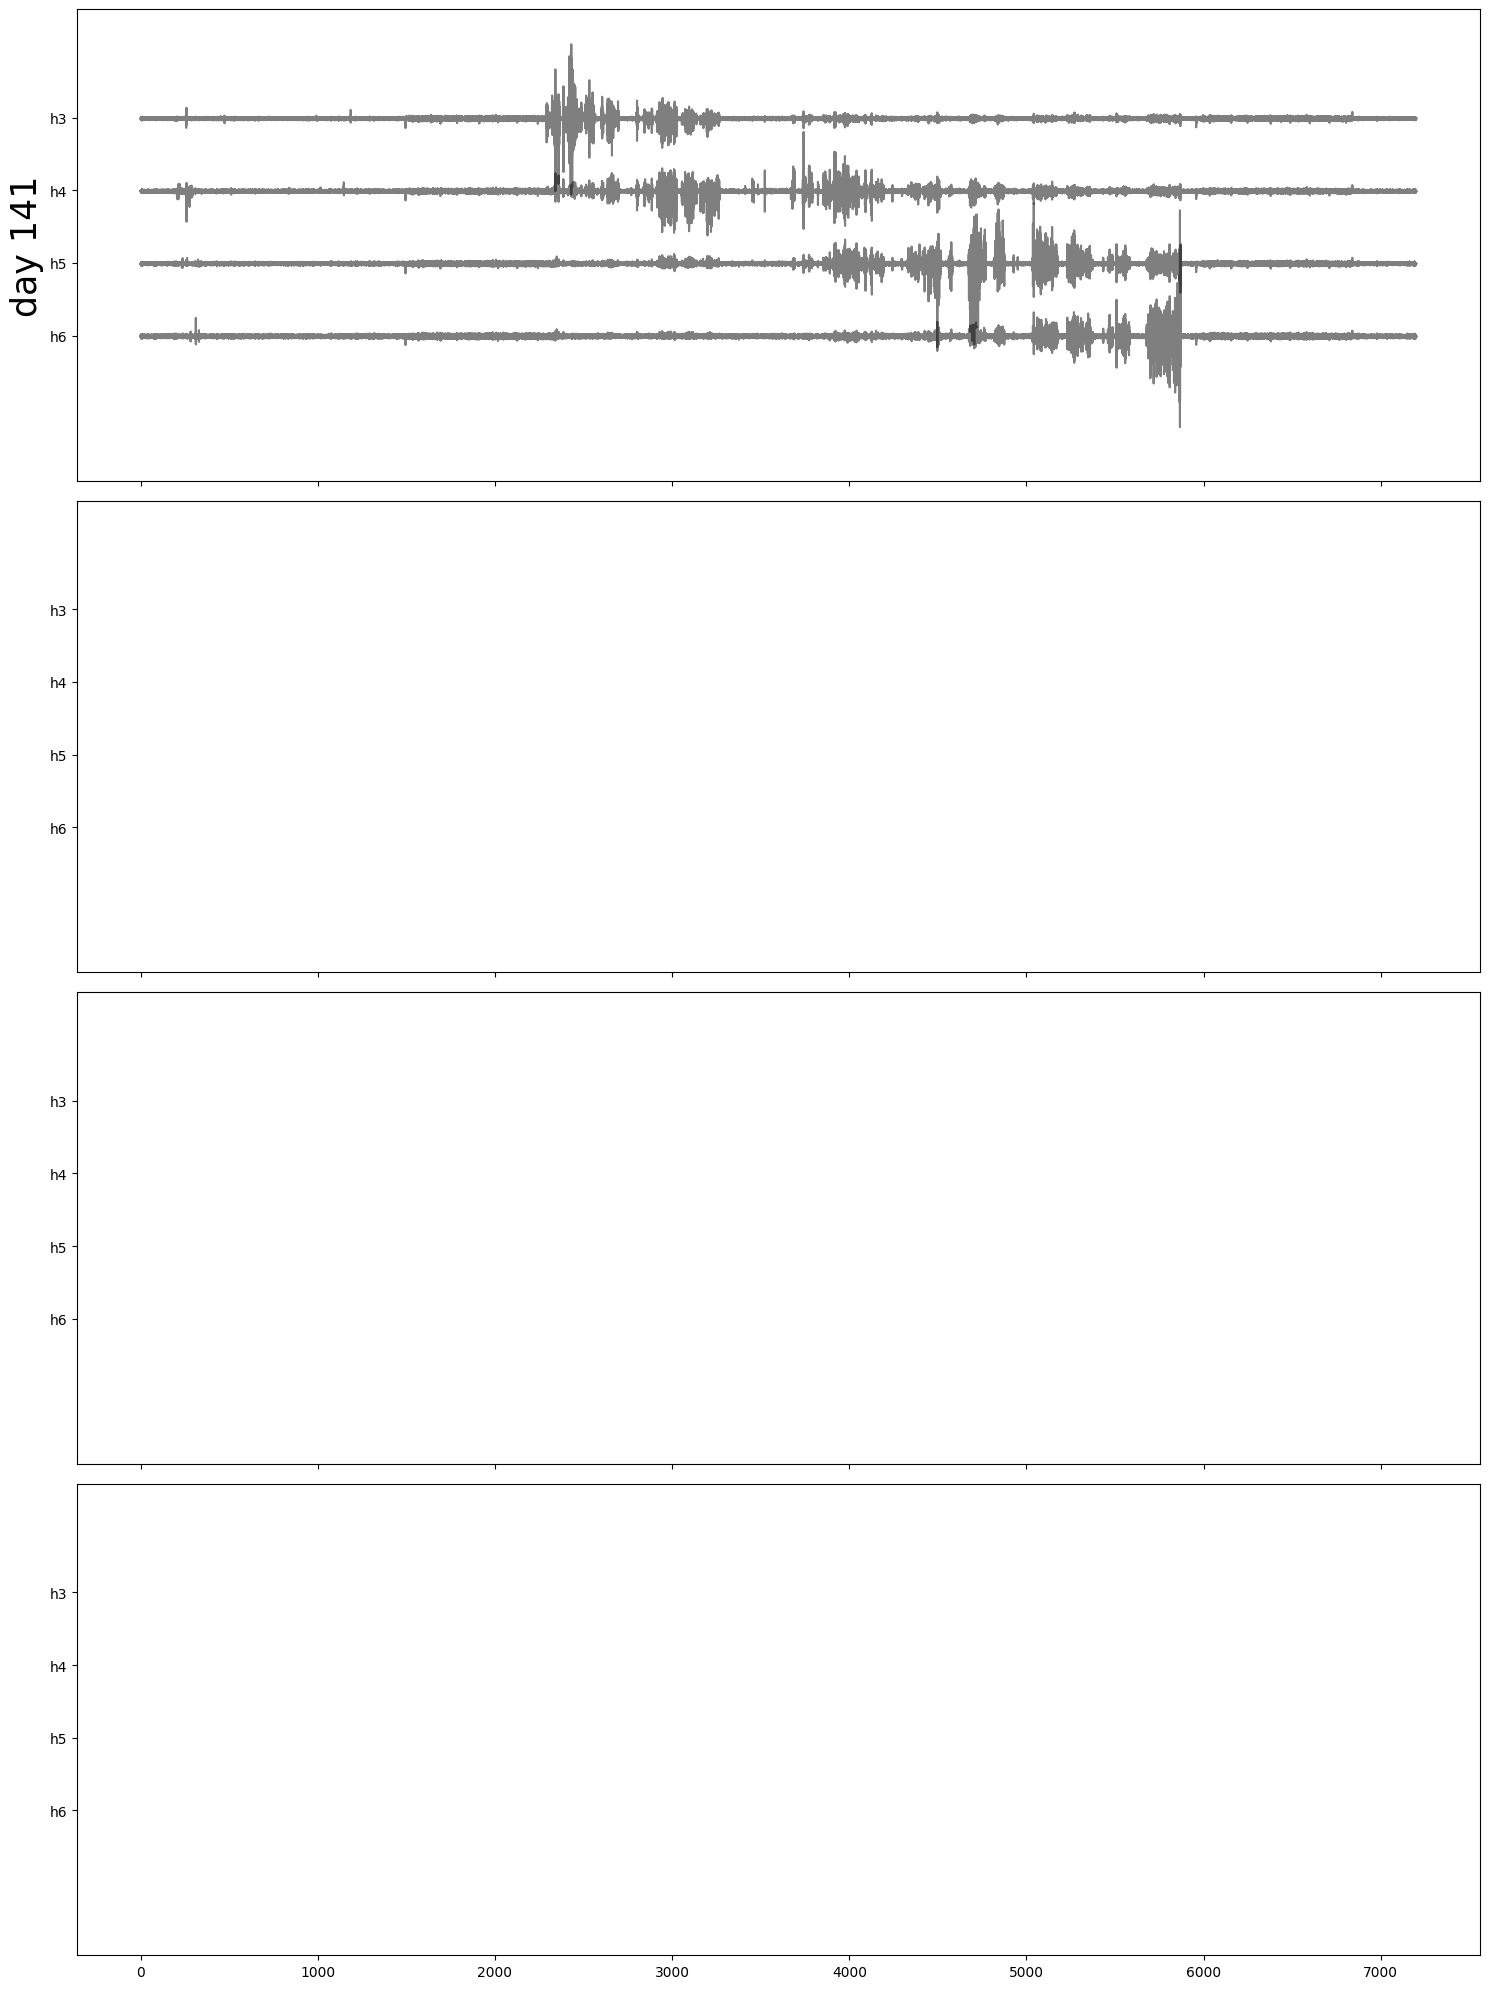

In [3]:
fig, ax = plt.subplots(4, 1, figsize=(15, 20), sharey=True, sharex=True)

def plot_waveform(ax, stream, day):
    times = np.array([tr.times() for tr in stream][2:])
    data = [tr.data for tr in stream][2:]
    n = 0
    for t, d in zip(times, data):
        ax.plot(t, d - n * 10, color='black', alpha=0.5)
        n+=1
        
    ax.set_ylabel('day ' + str(day), fontsize=25)

plot_waveform(ax=ax[0], stream=day141, day=141)
# plot_waveform(ax=ax[1], stream=day188, day=188)
# plot_waveform(ax=ax[2], stream=day197, day=197)
# plot_waveform(ax=ax[3], stream=day211, day=211)

ax[0].set_ylim(-50, 15)
ax[0].set_yticks([0, -10, -20, -30])
ax[0].set_yticklabels(['h3', 'h4', 'h5', 'h6'])

plt.tight_layout()

# fig.savefig('figures/raw_waveforms.pdf', bbox_inches='tight')

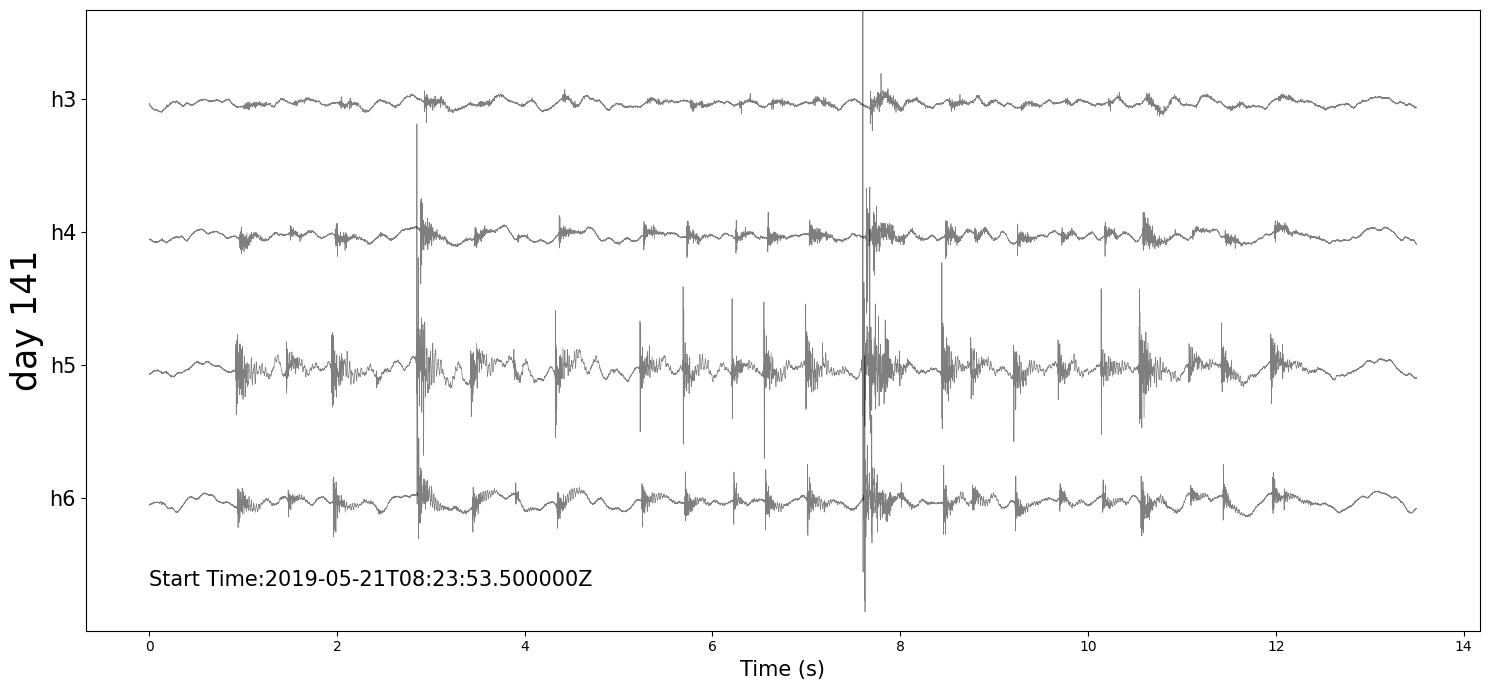

In [4]:
def plot_waveform(ax, stream, day):
    times = np.array([tr.times() for tr in stream][2:])
    data = [tr.data for tr in stream][2:]
    n = 0
    for t, d in zip(times, data):
        ax.plot(t, d - n * 3, color='black', linewidth=0.5, alpha=0.5)
        n+=1
        
    ax.set_ylabel('day ' + str(day), fontsize=25)

fig, ax = plt.subplots(figsize=(15, 7))
starttime = obspy.UTCDateTime('2019-05-21T08:23:53.500000Z')
endtime = obspy.UTCDateTime('2019-05-21T08:24:07.000000Z')
plot_waveform(ax=ax, stream=day141.copy().trim(starttime, endtime), day=141)
ax.set_ylim(-12, 2)
ax.set_yticks(np.array([0, -1, -2, -3])*3)
ax.set_yticklabels(['h3', 'h4', 'h5', 'h6'], fontsize=15)
ax.set_xlabel('Time (s)', fontsize=15)
ax.text(s=f'Start Time:{starttime}', x=0, y=-11, fontsize=15)
fig.tight_layout()
# fig.savefig('figures/zoom_swarm.pdf', bbox_inches='tight')

In [5]:

def import_catalog(file):
    df = pd.read_csv(file)
    df.sort_values(by='first_arrival', inplace=True)
    df['arrival_datetime'] = df.arrival_time.apply(dates.num2date)
    return df

def plot_depths(df, cmap, day):
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.scatter(df.arrival_datetime, df.depth, marker='.', linewidth=0, c=df.first_hydrophone, cmap=cmap)
    ax.set_ylabel('day '+str(day), fontsize=25)
    ax.set_ylim(400, 50)
    return fig, ax

In [6]:
df141 = import_catalog(file='141precision.csv')


In [7]:
# also need to remove a number of columns that are simply irrelevant to the analysis or untested for a shareable dataset.

columns_to_keep = ['id', 'depth', 'relative_depth',
        'first_hydrophone', 'second_hydrophone',
       'arrival_time', 'first_arrival', 'second_arrival', 'dt',
       'max_amp', 'cum_amp', 'arrival_datetime']

df141 = df141[columns_to_keep].copy()
# df188 = df188[columns_to_keep].copy()
# df197 = df197[columns_to_keep].copy()
# df211 = df211[columns_to_keep].copy()

df141.sort_values(by='arrival_datetime', inplace=True)
# df188.sort_values(by='arrival_datetime', inplace=True)
# df197.sort_values(by='arrival_datetime', inplace=True)
# df211.sort_values(by='arrival_datetime', inplace=True)

# # removing the events with maximum amplitude <0.1 since they are false positives
df141 = df141[df141.max_amp > 0.1].copy()
# df188 = df188[df188.max_amp > 0.1].copy()
# df197 = df197[df197.max_amp > 0.1].copy()
# df211 = df211[df211.max_amp > 0.1].copy()

df141.drop_duplicates(subset=['arrival_datetime',], inplace=True)
# df188.drop_duplicates(subset=['arrival_datetime',], inplace=True)
# df197.drop_duplicates(subset=['arrival_datetime',], inplace=True)
# df211.drop_duplicates(subset=['arrival_datetime',], inplace=True)

In [8]:
print('length of day 141 swarm in seconds:', pd.Timedelta(np.array(df141.arrival_datetime.tail(1).values - df141['arrival_datetime'].head(1).values)[0]).total_seconds())

length of day 141 swarm in seconds: 3545.596


In [9]:
print('day141 N-events:', df141.shape)
# print('day188 N-events:', df188.shape)
# print('day197 N-events:', df197.shape)
# print('day211 N-events:', df211.shape)

day141 N-events: (1931, 12)


In [10]:
def get_swarm_time_length(df):
    start = df.head(1).arrival_datetime.values
    end = df.tail(1).arrival_datetime.values
    tl = (end - start)/np.timedelta64(1, 's')
    return tl[0]
print('Day 141 event length:', get_swarm_time_length(df141))
# print('Day 188 event length:', get_swarm_time_length(df188))
# print('Day 197 event length:', get_swarm_time_length(df197))
# print('Day 211 event length:', get_swarm_time_length(df211))

Day 141 event length: 3545.596


In [25]:
from event_pipeline import Event
import torchaudio.transforms as T
import librosa
import torch

import matplotlib.dates as mdates
import datetime


def get_event(event_id, day_number, df, hanning=True):
    paths = useful_variables.make_hydrophone_data_paths(borehole='a', year=2019, julian_day=day_number)
    waveforms = load.import_corrected_data_for_single_day(paths=paths)
    df = df.copy()
    e = Event(id=event_id
              , starttime=df.arrival_time.loc[event_id]
              , init_first_hphone=df.first_hydrophone
              , waveforms=waveforms
              , hanning=hanning
             )
    return e

# def get_times(event, hydrophone_index):
def get_times(event):
    trace = event.stream[event.first_hydrophone_id]
    times = trace.times()
    times_len = times.shape[0]
    return np.arange(0, times_len, 1)

# def plot_spectrogram(event, hydrophone_index, ax):
def plot_spectrogram(event, ax):
    trace = event.stream[event.first_hydrophone_id]
    torch_data = torch.from_numpy(trace.data)
    spectrogram = T.Spectrogram(n_fft=2**6, hop_length=1)
    spec = spectrogram(torch_data)
    ax.imshow(librosa.power_to_db(spec), origin='lower', aspect='auto', cmap='gist_rainbow')
    

# def plot_50hz_highpass(event, hydrophone_index, ax):
def plot_50hz_highpass(event, ax):
    trace = event.stream[event.first_hydrophone_id]
    # times = get_times(event=event, hydrophone_index=hydrophone_index)
    times = get_times(event=event)
    tr = trace.filter(type='highpass', freq=50)
    ax.plot(times, tr.data, color='violet', label='50Hz highpass'
            ,linewidth=2)

# def plot_aic_pick(event, hydrophone_index, ax):
def plot_aic_pick(event, ax):
    # times = get_times(event=event, hydrophone_index=hydrophone_index)
    times = get_times(event=event)
    # aic_time = times[np.argmax(event.aics[hydrophone_index])
    # its 0.4 because its 2/5 because its 0.2s before and 0.3 after
    aic_time = times[int(0.4*times.shape[0])]
    ax.vlines(x=aic_time, ymin=-0.5, ymax=0.7, color='cyan'
              ,linewidth=3, label='AIC pick')

# def plot_parrival(event, ax):
#     tbefore = (event.starttime._get_datetime().replace(tzinfo=datetime.timezone.utc) - event.parrival).total_seconds()
#     print(tbefore)
#     ax.vlines(x=200 - tbefore, ymin=-0.5, ymax=0.7, color='red'
#               ,linewidth=3)

# def plot_p(event, hydrophone_index, ax):
def plot_p(event, ax):
    trace = event.stream[event.first_hydrophone_id]
    # times = get_times(event=event, hydrophone_index=hydrophone_index)
    times = get_times(event=event)
    tr = trace.filter(type='highpass', freq=50)
    
    # find max/min peak
    start = 180
    end = 199
    if np.max(tr.data[start:end]) > np.min(tr.data[start:end]):
        ploc_t = times[np.argmax(tr.data[start:end]) + start]
        ploc_y = np.max(tr.data[start:end])
    else:
        ploc_t = times[np.argmin(tr.data[start:end]) + start]
        ploc_y = np.min(tr.data[start:end])
    
    ax.plot(times, tr.data, color='cyan', alpha=0.5, label='what is this?')
    print(ploc_t, ploc_y)
    print(tr.data.shape)
    ax.plot(ploc_t, ploc_y, marker='*', linestyle='', color='red', label='p-arrival pick')

# def plot_aic(event, hydrophone_index, ax):
def plot_aic(event, ax):
    # times = get_times(event=event, hydrophone_index=hydrophone_index)
    times = get_times(event=event)
    AICs = event.aics[event.first_hydrophone_id]
    ax.plot(times, AICs, color='cyan', linewidth=2.5)

# def plot_aic_diff(event, hydrophone_index, ax):
def plot_aic_diff(event, ax):
    # times = get_times(event=event, hydrophone_index=hydrophone_index)
    times = get_times(event=event)
    # AICs = event.aics[hydrophone_index]
    AICs = event.aics[event.first_hydrophone_id]
    aic_diffs = np.diff(AICs)
    ax.plot(times[1:], aic_diffs, color='magenta')

def plot_event(event_id, day_number, df):
    
    e = get_event(event_id=event_id, day_number=day_number, df=df)
    # hydrophone_index = e.first_hydrophone_id
    
    fig, ax = plt.subplots(3, 1, figsize=(15, 8), sharex=True)
    # fig, ax = plt.subplots(3, 1, figsize=(15, 8))
    
    # plot_50hz_highpass(event=e, hydrophone_index=hydrophone_index, ax=ax[0])
    plot_50hz_highpass(event=e, ax=ax[0])
    
    # plot_aic_pick(event=e, hydrophone_index=hydrophone_index, ax=ax[0])
    plot_aic_pick(event=e,  ax=ax[0])
    # plot_parrival(event=e, ax=ax[0])
    
    # plot_p(event=e, hydrophone_index=hydrophone_index, ax=ax[0])
    plot_p(event=e, ax=ax[0])
    
    # plot_aic(event=e, hydrophone_index=hydrophone_index, ax=ax[1])
    plot_aic(event=e, ax=ax[1])
    
    ax2 = ax[1].twinx()
    
    # plot_aic_diff(event=e, hydrophone_index=hydrophone_index, ax=ax2)
    plot_aic_diff(event=e, ax=ax2)
    
    # plot_spectrogram(event=e, hydrophone_index=hydrophone_index, ax=ax[2])
    plot_spectrogram(event=e, ax=ax[2])
    
    ax[0].set_ylabel('Pressure (Pa)', fontsize=15)
    ax[0].legend(fontsize=15)
    ax[1].set_ylabel('AIC', fontsize=15, color='magenta')
    ax2.set_ylabel('diff(AIC)', fontsize=15, color='cyan')
    ax[2].set_ylabel('Hz', fontsize=15)
    ax[2].set_yticks(np.arange(0, 32, 5))
    ax[2].set_yticklabels(np.arange(0, 32, 5) * 500 / 32)
    fig.tight_layout()

195 0.016006146804557468
(501,)


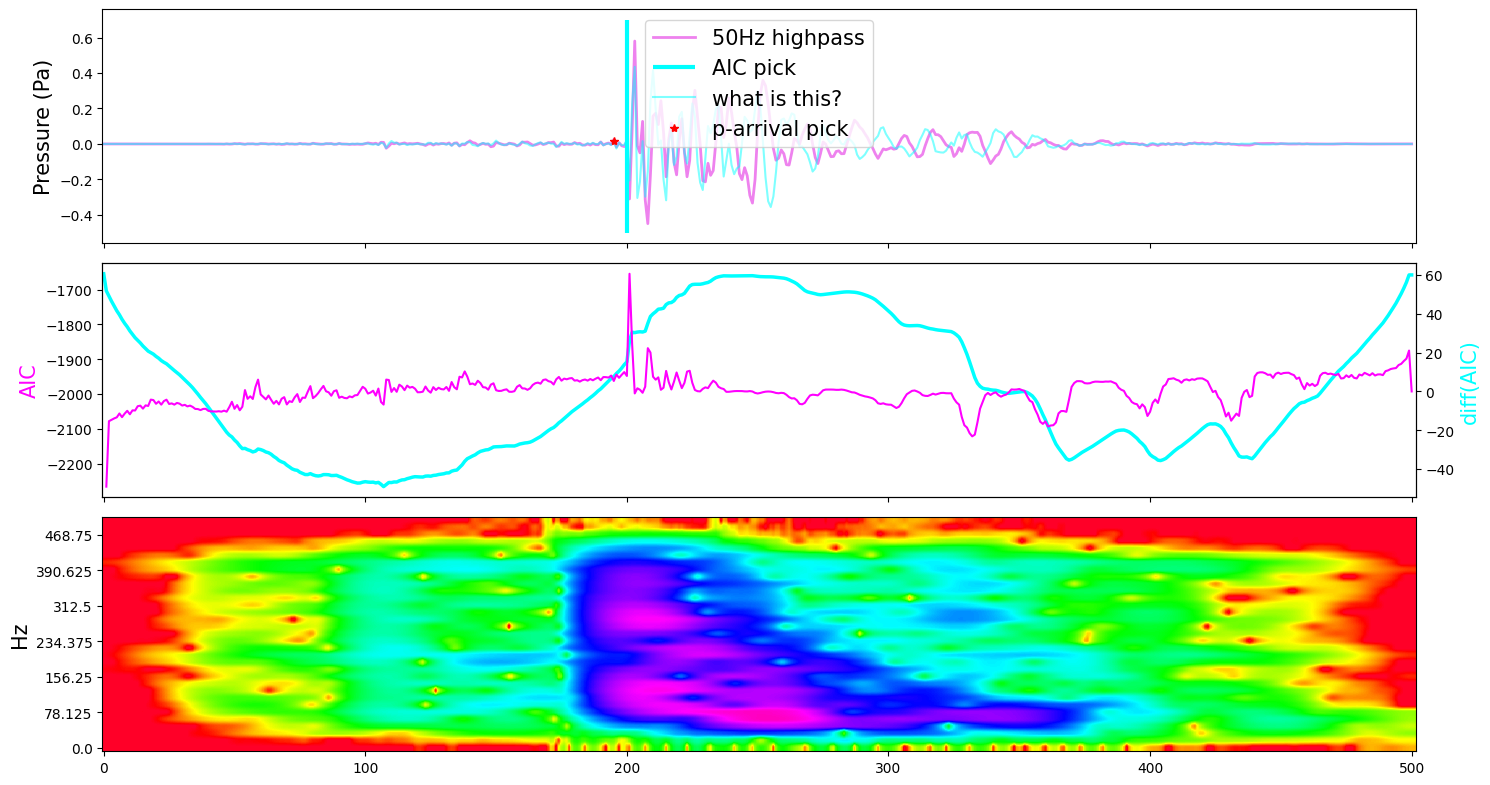

In [26]:
plot_event(event_id=1058, day_number=141, df=df141)

In [13]:
# YOU NEED TO ADD THE P-WAVE PICKER

In [14]:
# def moving_average(x, w):
#     return np.convolve(x, np.ones(w), 'valid') / w

# def plot_50hz_highpass(event, hydrophone_index, ax):
#     trace = event.stream[hydrophone_index]
#     times = get_times(event=event, hydrophone_index=hydrophone_index)
#     tr = trace.filter(type='highpass', freq=50)
#     ax.plot(times, tr.data, color='violet', label='50Hz highpass'
#             ,linewidth=0.5, alpha=0.5)


# def plot_p(event, hydrophone_index, ax):
#     trace = event.stream[hydrophone_index]
#     times = get_times(event=event, hydrophone_index=hydrophone_index)
#     tr = trace.filter(type='highpass', freq=50)
#     # psquare = tr.data*(-1)
    
#     # find max/min peak
#     start = 180
#     end = 199
#     if np.max(tr.data[start:end]) > np.min(tr.data[start:end]):
#         ploc_t = times[np.argmax(tr.data[start:end]) + start]
#         ploc_y = np.max(tr.data[start:end])
#     else:
#         ploc_t = times[np.argmin(tr.data[start:end]) + start]
#         ploc_y = np.min(tr.data[start:end])
    
#     ax.plot(times, tr.data, color='cyan', alpha=0.5)
#     print(ploc_t, ploc_y)
#     print(tr.data.shape)
#     ax.plot(ploc_t, ploc_y, marker='*', color='red')

# ids = df141.id.sample(10)

# fig, ax = plt.subplots(2, 1, figsize=(15, 5))

# for id in ids:

#     e = get_event(event_id=id, day_number=141, df=df141, hanning=False)
#     plot_50hz_highpass(event=e, hydrophone_index=e.first_hydrophone_id, ax=ax[0])
#     # plot_50hz_highpass(event=e, hydrophone_index=e.first_hydrophone_id, ax=ax[1])
#     plot_p(event=e, hydrophone_index=e.first_hydrophone_id, ax=ax[1])

# xstart = 190
# xend = 200
# ax[0].vlines(x=xstart, ymin=-3, ymax=5)
# ax[0].vlines(x=xend, ymin=-3, ymax=5)
# ax[1].set_xlim(xstart, xend)
# ax[1].set_ylim(-0.3, 0.3)

# # plt.plot(e.stream[e.first_hydrophone_id].data)
# # plt.plot(moving_average(x=e.stream[e.first_hydrophone_id].data[0:200], w=15))

In [15]:
# (e.starttime._get_datetime().replace(tzinfo=datetime.timezone.utc) - e.parrival).total_seconds()

In [16]:
# e.first_hydrophone_id

In [17]:
# dates.num2date(e.aic_t[4])

In [18]:
# e.starttime._get_datetime()